# Topics

This notebooks explores the time response of a dynamic system. 

The systems of interest in this section are the ones exibiting stable oscillatory behaviour, that is, ones with stable fixed points that are spiral sinks.

Some of the topics covered:

- Oscillation Characteristics
  - Frequency
  - Amplitude
  - Phase Shift
- Control Metrics
  - Overshoot
  - Undershoot
  - Settling Time
  - Rise Time
- Envelopes

# Initial Configuration

In [1]:
import os
import pickle
import pprint
import time
from collections import defaultdict
from datetime import datetime

import pandas as pd
import sympy as sy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import clear_output

In [2]:
# General Purpose
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, interactive, HBox, VBox

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [3]:
plt.style.use('bmh')

In [4]:
def round_expr(expr, num_digits=2):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sy.Number)})

In [5]:
import sympy as sy
from collections import namedtuple

FIELDS = (
    "equilibrium_x",
    "equilibrium_y",
    "natural_frequency",
    "period",
    "damping_ratio",
    "decay_rate",
    "trace",
    "determinant",
    "discriminant",
)
AnalysisResults = namedtuple('AnalysisResults', FIELDS)

def find_equilibrium_point(function):
    x, y = sy.symbols('x, y')
    equations = sy.Matrix(function([x, y], 0))
    
    equilibrium_solutions = sy.solve(sy.Eq(equations, sy.Matrix([0, 0])), [x, y], dict=True)
    equilibrium_solutions = equilibrium_solutions[0] if len(equilibrium_solutions) else equilibrium_solutions
    x_equilibrium = equilibrium_solutions.get(x, 0)
    y_equilibrium = equilibrium_solutions.get(y, 0)

    return x_equilibrium, y_equilibrium

def find_jacobian_at_equilibrium(function, equilibrium_point):
    x, y = sy.symbols('x, y')
    equations = sy.Matrix(function([x, y], 0))
    jacobian = equations.jacobian([x, y])
    x_equilibrium, y_equilibrium = equilibrium_point
    return jacobian.subs({x: x_equilibrium, y: y_equilibrium})

def compute_matrix_characteristics(jacobian_at_equilibrium):
    trace = sy.Trace(jacobian_at_equilibrium).simplify()
    determinant = jacobian_at_equilibrium.det().simplify()

    discriminant = trace ** 2 - 4 * determinant
    
    eigenvalues = sy.Matrix(list(jacobian_at_equilibrium.eigenvals()))
    decay_rate = abs(sy.re(eigenvalues)[0])
    
    natural_frequency = abs(sy.im(eigenvalues)[0])
    
    return trace, determinant, discriminant, natural_frequency, decay_rate

def analyse(function):
    equilibrium_point = find_equilibrium_point(function)
    
    jacobian_at_equilibrium = find_jacobian_at_equilibrium(function, equilibrium_point)
    
    trace, determinant, discriminant, natural_frequency, decay_rate = compute_matrix_characteristics(jacobian_at_equilibrium)

    damping_ratio = decay_rate / (decay_rate**2 + natural_frequency**2)**0.5

    period = (2 * np.pi) / natural_frequency
    
    return AnalysisResults(
        *equilibrium_point,
        natural_frequency,
        period,
        damping_ratio,
        decay_rate,
        trace,
        determinant,
        discriminant,
    )

In [6]:
def get_general_solution(analysis_results, offset):
    C1, C2, t = sy.symbols('C1 C2 t')

    exponential_decay = sy.exp(-analysis_results.decay_rate*t)
    periodic_oscillation = C1 * sy.cos(analysis_results.natural_frequency*t) + C2 * sy.sin(analysis_results.natural_frequency*t)
    return exponential_decay * periodic_oscillation + offset

def compute_solution_coefficients(initial_condition, initial_condition_delta, offset, analysis_results):
    C1, C2, t = sy.symbols('C1 C2 t')

    general_solution_form = get_general_solution(analysis_results, offset)

    initial_condition_equation = sy.Eq(general_solution_form.subs(t, 0), initial_condition)

    C1_solution = float(sy.solve(initial_condition_equation, C1)[0])
    
    general_solution_first_derivative_at_initial_time = sy.diff(general_solution_form, t).subs(t, 0)

    C2_equation = sy.Eq(general_solution_first_derivative_at_initial_time, initial_condition_delta)

    C2_solution = float(sy.solve(C2_equation.subs(C1, C1_solution), C2)[0])

    return C1_solution, C2_solution


def compute_amplitude_and_shift(analysis_results, coefficients):
    C1, C2 = coefficients
    
    amplitude = np.linalg.vector_norm(coefficients)
    
    phase_shift_radians = np.arctan2(C2, C1)
    phase_shift_radians = phase_shift_radians + (phase_shift_radians < 0) *  np.pi

    phase_shift_time = phase_shift_radians / analysis_results.natural_frequency

    return amplitude, (phase_shift_radians, phase_shift_time)

   
def compute_envelope(xs, amplitude, offset, analysis_results):
    envelope_exponential_decay = amplitude * np.exp(-xs * float(analysis_results.decay_rate))
    
    upper_envelop = offset + envelope_exponential_decay
    lower_envelop = offset - envelope_exponential_decay
    envelope_label = f"{offset:.2f} \pm {amplitude:.2f}" "e^{" f"{analysis_results.decay_rate:.2f}" "t}"
    return upper_envelop, lower_envelop, envelope_label

<>:44: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2622/3547204247.py:44: SyntaxWarning: invalid escape sequence '\p'
  envelope_label = f"{offset:.2f} \pm {amplitude:.2f}" "e^{" f"{analysis_results.decay_rate:.2f}" "t}"


In [130]:
def solve_for_minimum_positive(expression, variable, min_threshold=None):
    solution = sy.solve([expression], [variable])
    print(f"{solution=}")
    solutions = []
    for initial_guess in np.linspace(0, 10, 40):
        try:
            solution = sy.nsolve([expression], [variable], initial_guess)[0]
            if min_threshold is not None and solution <= min_threshold:
                continue
            solutions.append(solution)
        except:
            continue
    return min(solutions)

def compute_ovoershoot(coefficients, analysis_results, offset):
    C1, C2, t = sy.symbols('C1 C2 t')
    C1_solution, C2_solution = coefficients
    
    general_solution = get_general_solution(analysis_results, offset)
    particular_solution = general_solution.subs({C1: C1_solution, C2: C2_solution})
    particular_solution_derivative = particular_solution.diff(t)
    first_critical_point_time = float(sy.solve(particular_solution_derivative, t)[0])

    half_period = analysis_results.period / 2

    first_critical_point_time += 0 if first_critical_point_time >= 0 else abs(first_critical_point_time // half_period) * half_period
        
    second_critical_point_time = first_critical_point_time + half_period

    first_critical_point_value = float(particular_solution.subs({t: first_critical_point_time}))
    second_critical_point_value = float(particular_solution.subs({t: second_critical_point_time}))

    overshoot = first_critical_point_time, first_critical_point_value
    undershoot = second_critical_point_time, second_critical_point_value

    if first_critical_point_value < offset:
        overshoot, undershoot = undershoot, overshoot

    return overshoot, undershoot

In [119]:
def compute_settling_time(analysis_results, tolerance=.05):
    settling_time = - np.log(tolerance) / analysis_results.decay_rate
    return settling_time
    

In [120]:
def plot_system(time, x_solution, y_solution, analysis_results, function, initial_conditions, initial_deltas):
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas
    
    fig, ax = plt.subplots(figsize=(12, 8), layout="tight")

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1
    
    ax.plot(time, x_solution, label='x(t)', color="royalblue")

    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_phase_shift = compute_amplitude_and_shift(x_coefficients, analysis_results)
        x_upper_envelope, x_lower_envelope = compute_envelope(time, x_amplitude, analysis_results.equilibrium_x, analysis_results)
        
        ax.plot(time, x_upper_envelope, color="royalblue", ls="--")
        ax.plot(time, x_lower_envelope, color="royalblue", ls="--")
    
        x_overshoot, x_undershoot = compute_ovoershoot(x_coefficients, analysis_results, analysis_results.equilibrium_x)
        ax.scatter(*x_overshoot, color="royalblue", ls="--")
        ax.scatter(*x_undershoot, color="royalblue", ls="--")

    settling_time = compute_settling_time(analysis_results)
    ax.axvline(settling_time, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_x * 1.05, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_x * 0.95, color="goldenrod", ls="--")
    
    ax.plot(time, y_solution, label='y(t)', color="firebrick")

    if system_has_oscillations:
        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_phase_shift = compute_amplitude_and_shift(y_coefficients, analysis_results)
        y_upper_envelope, y_lower_envelope = compute_envelope(time, y_amplitude, analysis_results.equilibrium_y, analysis_results)
        ax.plot(time, y_upper_envelope, color="firebrick", ls="--")
        ax.plot(time, y_lower_envelope, color="firebrick", ls="--")

        y_overshoot, y_undershoot = compute_ovoershoot(y_coefficients, analysis_results, analysis_results.equilibrium_y)
        ax.scatter(*y_overshoot, color="firebrick", ls="--")
        ax.scatter(*y_undershoot, color="firebrick", ls="--")

    ax.axhline(analysis_results.equilibrium_y * 1.05, color="goldenrod", ls="--")
    ax.axhline(analysis_results.equilibrium_y * 0.95, color="goldenrod", ls="--")
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    
    handles += [proxy_artist]
    labels += [f"$A_x={x_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$A_y={y_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$\phi_x={x_phase_shift:.2f} rad$"]

    handles += [proxy_artist]
    labels += [f"$\phi_y={y_phase_shift:.2f} rad$"]

    ax.legend(handles, labels, loc='best')
    ax.set_title("X and Y over Time")

    plt.show()   
    

<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2622/2370163619.py:54: SyntaxWarning: invalid escape sequence '\p'
  labels += [f"$\phi_x={x_phase_shift:.2f} rad$"]
/tmp/ipykernel_2622/2370163619.py:57: SyntaxWarning: invalid escape sequence '\p'
  labels += [f"$\phi_y={y_phase_shift:.2f} rad$"]


# Autonomous Systems

In [121]:
# def main(A, B, C, D, x_0, y_0, days):
#     def function(S, time):
#         x, y = S
#         return [
#             A * x + B * y ,
#             C * x + D * y
#         ]

#     anaysis_result = analyse(function)
    
#     time = np.linspace(0, days, days*10)
#     initial_conditions = [x_0, y_0]
#     initial_deltas = function([x_0, y_0], 0)
    
#     solution = odeint(function, initial_conditions, time)

#     x_solution, y_solution = solution.T

#     plot_system(time, x_solution, y_solution, anaysis_result, function, initial_conditions, initial_deltas)

In [122]:
# interact(
#     main,
#     A=FloatSlider(min=-5, max=5, step=0.1, value=0, description='A', style=style, layout=slider_layout),
#     B=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='B', style=style, layout=slider_layout),
#     C=FloatSlider(min=-5, max=5, step=0.1, value=0.5, description='C', style=style, layout=slider_layout),
#     D=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='D', style=style, layout=slider_layout),
#     x_0=FloatSlider(min=0, max=10, step=1, value=1, description='x_0', style=style, layout=slider_layout),
#     y_0=FloatSlider(min=0, max=10, step=1, value=1, description='y_0', style=style, layout=slider_layout),
#     days=IntSlider(min=1, max=360, step=10, value=101, description='t', style=style, layout=slider_layout),
# );

In [123]:
# main(
#     A=0,
#     B=-1.00,
#     C=2.00,
#     D=-0.10,
#     x_0=1,
#     y_0=1,
#     days=100,
# );

# Wave Characteristics

In [13]:
def get_particular_solution(coefficients, analysis_results, offset, amplitude, phase):
    C1, C2 = coefficients
    t = sy.symbols('t')

    alpha = analysis_results.decay_rate
    omega = analysis_results.natural_frequency
    
    exponential_decay = "e^{" f"{-analysis_results.decay_rate:.2f}" "t}"
    cosine_component = f"{C1:.2f}\cdot\cos({analysis_results.natural_frequency:.2f} t)"
    sine_component = f"{C2:+.2f}\cdot\sin({analysis_results.natural_frequency:.2f} t)"
    sine_cosine_form = f"{exponential_decay} \cdot ({cosine_component} {sine_component})"
    
    cosine_component = f"cos({analysis_results.natural_frequency:.2f} t - \phi)"
    amplitude_phase_form = f"{offset:.2f} + {amplitude:.2f} \cdot {exponential_decay} \cdot {cosine_component}"
    return f"{sine_cosine_form}={amplitude_phase_form}"

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2622/14258070.py:9: SyntaxWarning: invalid escape sequence '\c'
  cosine_component = f"{C1:.2f}\cdot\cos({analysis_results.natural_frequency:.2f} t)"
/tmp/ipykernel_2622/14258070.py:10: SyntaxWarning: invalid escape sequence '\c'
  sine_component = f"{C2:+.2f}\cdot\sin({analysis_results.natural_frequency:.2f} t)"
/tmp/ipykernel_2622/14258070.py:11: SyntaxWarning: invalid e

In [14]:
def plot_wave_characteristics(time, solution, analysis_results, function, initial_conditions, initial_deltas):
    x_solution, y_solution = solution
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1

    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_phase_shift = compute_amplitude_and_shift(analysis_results, x_coefficients) #(analysis_results, x_coefficients)
        x_phase_shift_radians, x_phase_shift_time = x_phase_shift
        x_wave_form = get_particular_solution(x_coefficients, analysis_results, analysis_results.equilibrium_x, x_amplitude, x_phase_shift_radians)


        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_phase_shift = compute_amplitude_and_shift(analysis_results, y_coefficients) # (analysis_results, y_coefficients)
        y_phase_shift_radians, y_phase_shift_time = y_phase_shift
        y_wave_form = get_particular_solution(y_coefficients, analysis_results, analysis_results.equilibrium_y, y_amplitude, y_phase_shift_radians)

    fig, axes = plt.subplots(figsize=(18, 6), layout="tight")

    ax = axes
    ax.plot(time, x_solution, label=f'$x(t): {x_wave_form}$', color="royalblue", lw=1, alpha=.5)
    ax.axhline(analysis_results.equilibrium_x, color="royalblue", ls="--", lw=1)

    ax.axvline(x_phase_shift_time, color="royalblue", ls="--", lw=1)
    # ax.annotate('Phase Shift',
    #         xy=(float(x_phase_shift_time), x_amplitude + analysis_results.equilibrium_x + 1), xycoords='data',
    #         xytext=(70, 0), textcoords='offset points',
    #         arrowprops=dict(facecolor='black'),
    #         horizontalalignment='center', verticalalignment='center')
    # ax.annotate('',
    #         xy=(0, x_amplitude + analysis_results.equilibrium_x + 1), xycoords='data',
    #         xytext=(-40, 0), textcoords='offset points',
    #         arrowprops=dict(facecolor='black'),
    #         horizontalalignment='center', verticalalignment='center')
    

    ys = analysis_results.equilibrium_x + x_amplitude * np.cos(float(analysis_results.natural_frequency) * time - x_phase_shift_radians)
    ax.plot(time, ys, color="royalblue", ls="-.") 


    
    ax.plot(time, y_solution, label=f'$y(t): {y_wave_form}$', color="firebrick", lw=1, alpha=.5)
    ax.axhline(analysis_results.equilibrium_y, color="firebrick", ls="--", lw=1)    

    ax.axvline(y_phase_shift_time, color="firebrick", ls="--", lw=1)

    ys = analysis_results.equilibrium_y + y_amplitude * np.cos(float(analysis_results.natural_frequency) * time - y_phase_shift_radians)
    ax.plot(time, ys, color="firebrick", ls="-.") 
    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)

    handles += [proxy_artist]
    labels += [f"$A_x={x_amplitude:.2f}$   $A_y={y_amplitude:.2f}$"]

    handles += [proxy_artist]
    labels += [f"$\phi_x={x_phase_shift_radians:.2f} rad = {x_phase_shift_time:.2f}s$    $\phi_y={y_phase_shift_radians:.2f} rad= {y_phase_shift_time:.2f}s$"]

    handles += [proxy_artist]
    labels += [f"$f_x=f_y={analysis_results.natural_frequency:.2f} rads/s$    $T_x=T_y={analysis_results.period:.2f} s$"]

    ax.legend(handles, labels, loc='upper right')
    ax.set_title("X and Y over Time")

    plt.show()   
    

<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:59: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2622/988411179.py:59: SyntaxWarning: invalid escape sequence '\p'
  labels += [f"$\phi_x={x_phase_shift_radians:.2f} rad = {x_phase_shift_time:.2f}s$    $\phi_y={y_phase_shift_radians:.2f} rad= {y_phase_shift_time:.2f}s$"]
/tmp/ipykernel_2622/988411179.py:59: SyntaxWarning: invalid escape sequence '\p'
  labels += [f"$\phi_x={x_phase_shift_radians:.2f} rad = {x_phase_shift_time:.2f}s$    $\phi_y={y_phase_shift_radians:.2f} rad= {y_phase_shift_time:.2f}s$"]


In [124]:
def system(A, B, C, D, offset=(0, 0)):
    def function(S, time):
        x, y = S
        x_offset, y_offset = offset
        x_off = (x - x_offset)
        y_off = (y - y_offset)
        return [
            A * x_off + B * y_off,
            C * x_off + D * y_off
        ]
    return function

def main(A, B, C, D, x_0, y_0, days):
    function = system(A, B, C, D, (10, 100))

    initial_conditions = [x_0, y_0]
    
    analysis_result = analyse(function)
    
    time = np.linspace(0, days, days*10)
    initial_deltas = function(initial_conditions, 0)
    solution = odeint(function, initial_conditions, time).T

    plot_wave_characteristics(time, solution, analysis_result, function, initial_conditions, initial_deltas)

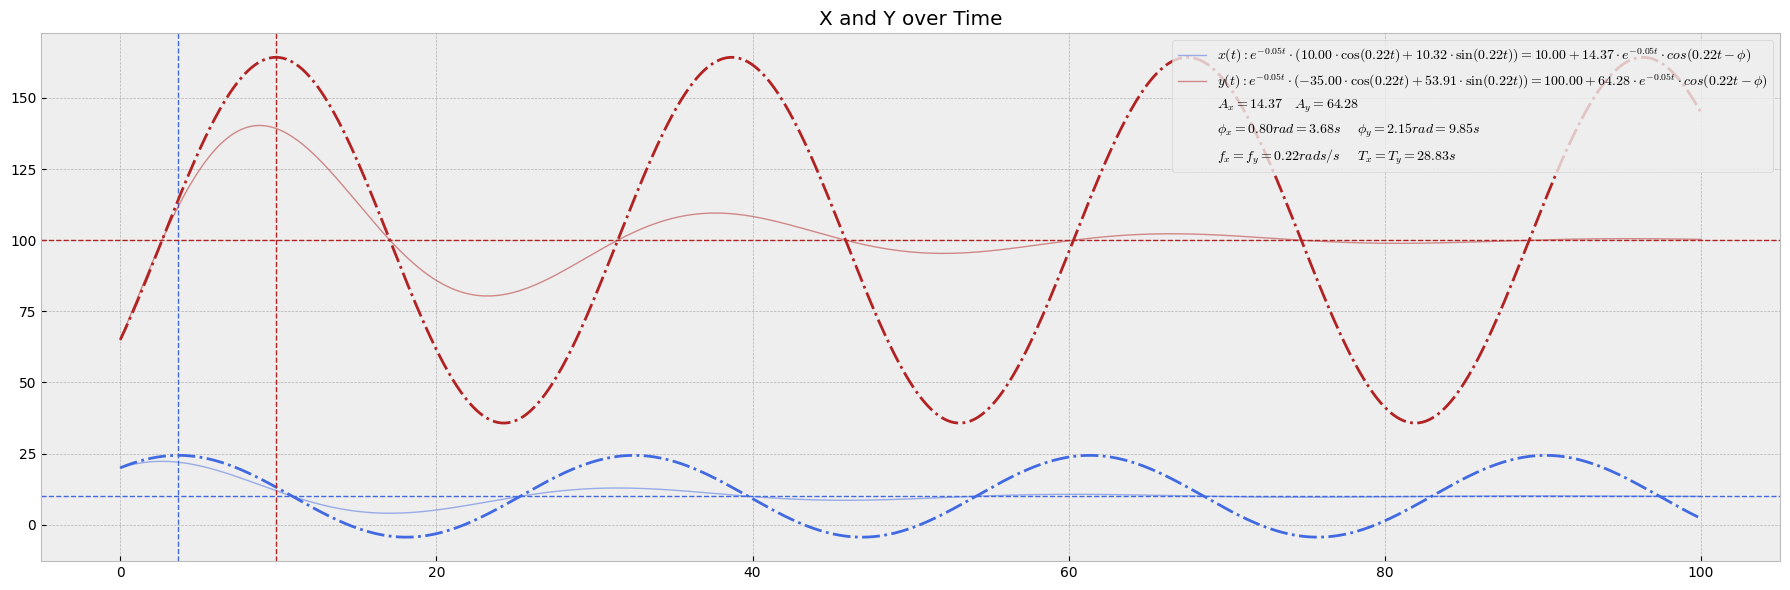

In [125]:
main(
    A=0,
    B=-0.05,
    C=1.00,
    D=-0.10,
    x_0=20,
    y_0=65,
    days=100,
);

# Envelope

In [107]:
def get_general_function(analysis_results, offset, amplitude, phase="\phi"):
    exponential_decay = "e^{" f"{-analysis_results.decay_rate:.2f}" "t}"
    cosine_component = f"cos({analysis_results.natural_frequency:.2f} t - {phase})"
    return f"{offset:.2f} + {amplitude:.2f} \cdot {exponential_decay} \cdot {cosine_component}"

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2622/2502323378.py:1: SyntaxWarning: invalid escape sequence '\p'
  def get_general_function(analysis_results, offset, amplitude, phase="\phi"):
/tmp/ipykernel_2622/2502323378.py:4: SyntaxWarning: invalid escape sequence '\c'
  return f"{offset:.2f} + {amplitude:.2f} \cdot {exponential_decay} \cdot {cosine_component}"
/tmp/ipykernel_2622/2502323378.py:4: SyntaxWarning: invalid escape sequence '\c'
  return f"{offset:.2f} + {amplitude:.2f} \cdot {exponential_decay} \cdot {cosine_component}"


In [108]:
def plot_phase_shifts(xs, offset, amplitude, analysis_results, *, ax, color) -> None:
    alpha = float(analysis_results.decay_rate)
    omega = float(analysis_results.natural_frequency)

    for phi in np.linspace(-np.pi, np.pi, 15, endpoint=False):
        ys = offset + np.exp(-alpha*xs) * amplitude * np.cos(omega * xs - phi)
        ax.plot(xs, ys, color=color, alpha=0.2)

In [109]:
def plot_wave_envelope(time, solution, analysis_results, function, initial_conditions, initial_deltas):
    x_solution, y_solution = solution
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1

    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_phase_shift = compute_amplitude_and_shift(analysis_results, x_coefficients)
        x_upper_envelope, x_lower_envelope, x_envelope_label = compute_envelope(time, x_amplitude, analysis_results.equilibrium_x, analysis_results)
        
        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_phase_shift = compute_amplitude_and_shift(analysis_results, y_coefficients)
        y_upper_envelope, y_lower_envelope, y_envelope_label = compute_envelope(time, y_amplitude, analysis_results.equilibrium_y, analysis_results)
        

    fig, axes = plt.subplots(figsize=(18, 6), layout="tight")

    ax = axes

    x_solutions = get_general_function(analysis_results, analysis_results.equilibrium_x, x_amplitude)
    ax.plot(time, x_solution, label=f"$x(t): {x_solutions}$", color="royalblue")
    ax.plot(time, x_upper_envelope, color="royalblue", ls="--", label=f"$Envelope_x(t): {x_envelope_label}$")
    ax.plot(time, x_lower_envelope, color="royalblue", ls="--")
    ax.axhline(analysis_results.equilibrium_x, color="royalblue", ls="--", lw=1)
    plot_phase_shifts(time, analysis_results.equilibrium_x, x_amplitude, analysis_results, ax=ax, color="royalblue")


    y_solutions = get_general_function(analysis_results, analysis_results.equilibrium_y, y_amplitude)
    ax.plot(time, y_solution, color="firebrick", label=f"$y(t): {y_solutions}$")
    ax.plot(time, y_upper_envelope, color="firebrick", ls="--", label=f"$Envelope_y(t): {y_envelope_label}$")
    ax.plot(time, y_lower_envelope, color="firebrick", ls="--")
    ax.axhline(analysis_results.equilibrium_y, color="firebrick", ls="--", lw=1)    
    plot_phase_shifts(time, analysis_results.equilibrium_y, y_amplitude, analysis_results, ax=ax, color="firebrick")

    ax.legend(loc='upper right')
    ax.set_title("X and Y over Time")

    plt.show()   
    

In [110]:
def system(A, B, C, D, offset=(0, 0)):
    def function(S, time):
        x, y = S
        x_offset, y_offset = offset
        x_off = (x - x_offset)
        y_off = (y - y_offset)
        return [
            A * x_off + B * y_off,
            C * x_off + D * y_off
        ]
    return function

def main(A, B, C, D, x_0, y_0, x_offset, y_offset, days):
    function = system(A, B, C, D, (x_offset, y_offset))

    initial_conditions = [x_0, y_0]
    
    anaysis_result = analyse(function)
    
    time = np.linspace(0, days, days*10)
    initial_deltas = function(initial_conditions, 0)
    solution = odeint(function, initial_conditions, time).T

    plot_wave_envelope(time, solution, anaysis_result, function, initial_conditions, initial_deltas)

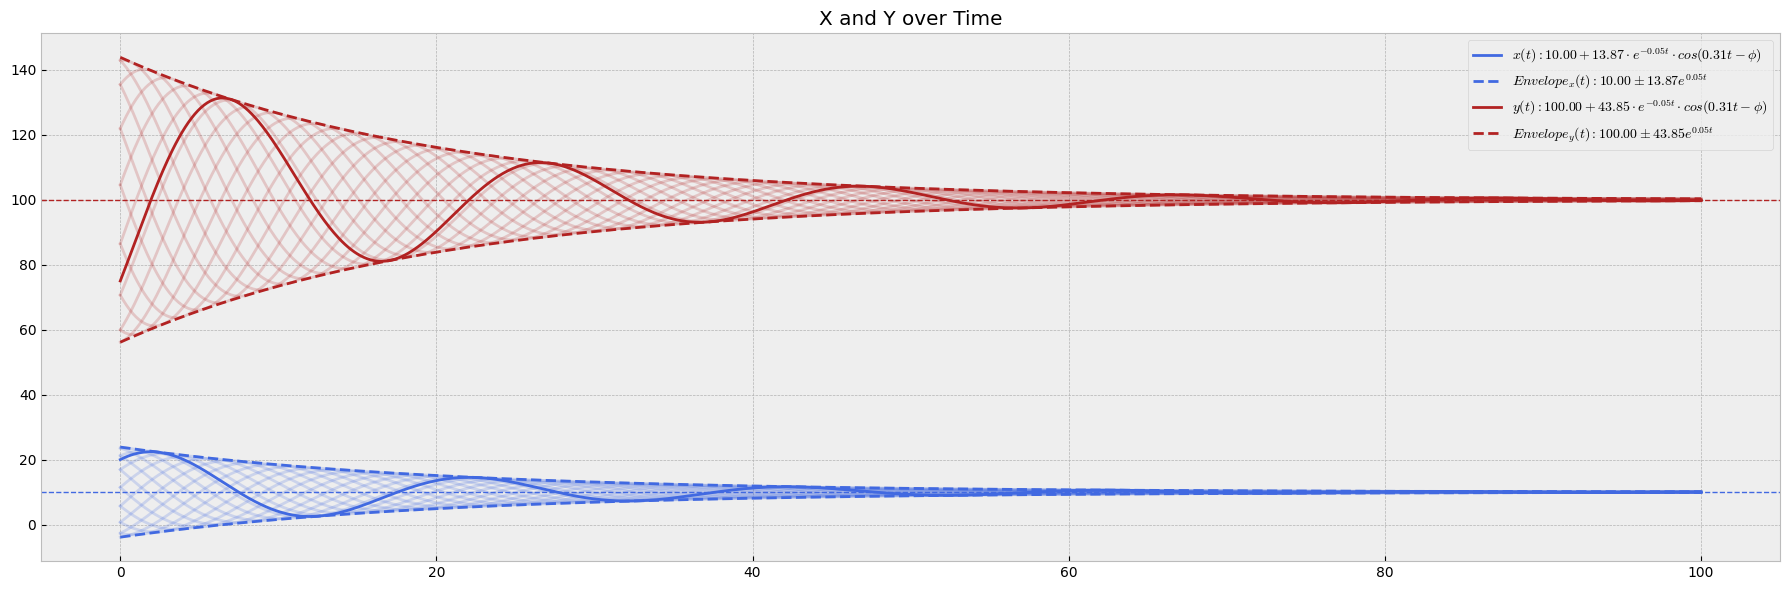

In [111]:
main(
    A=0,
    B=-0.1,
    C=1.00,
    D=-0.10,
    x_0=20,
    y_0=75,
    x_offset=10,
    y_offset=100,
    days=100,
);

# Control Metrics

In [115]:
def plot_overshoot_undershoot(overshoot, undershoot, equilibrium, *, ax, overshoot_color="forestgreen", undershoot_color="goldenrod"):
    overshoot_time, overshoot_value = overshoot
    undershoot_time, undershoot_value = undershoot

    ax.plot([overshoot_time, overshoot_time], [equilibrium, overshoot_value], color=overshoot_color, ls="--")
    ax.plot([overshoot_time-2, overshoot_time+2], [overshoot_value, overshoot_value], color=overshoot_color, ls="--")
    
    ax.plot([undershoot_time, undershoot_time], [equilibrium, undershoot_value], color=undershoot_color, ls="--")
    ax.plot([undershoot_time-2, undershoot_time+2], [undershoot_value, undershoot_value], color=undershoot_color, ls="--")

def plot_control_metrics(time, solution, analysis_results, function, initial_conditions, initial_deltas):
    x_solution, y_solution = solution
    x_0, y_0 = initial_conditions
    delta_x_0, delta_y_0 = initial_deltas

    system_has_oscillations = 0 < analysis_results.damping_ratio < 1

    if system_has_oscillations:
        x_coefficients = compute_solution_coefficients(x_0, delta_x_0, analysis_results.equilibrium_x, analysis_results)
        x_amplitude, x_phase_shift = compute_amplitude_and_shift(analysis_results, x_coefficients)
        x_overshoot, x_undershoot = compute_ovoershoot(x_coefficients, analysis_results, analysis_results.equilibrium_x)
        x_overshoot_time, x_overshoot_value = x_overshoot
        x_undershoot_time, x_undershoot_value = x_undershoot

        y_coefficients = compute_solution_coefficients(y_0, delta_y_0, analysis_results.equilibrium_y, analysis_results)
        y_amplitude, y_phase_shift = compute_amplitude_and_shift(analysis_results, y_coefficients)
        y_overshoot, y_undershoot = compute_ovoershoot(y_coefficients, analysis_results, analysis_results.equilibrium_y)
        y_overshoot_time, y_overshoot_value = y_overshoot
        y_undershoot_time, y_undershoot_value = y_undershoot


    fig, axes = plt.subplots(figsize=(18, 6), layout="tight")

    ax = axes
    overshoot_color = "forestgreen"
    undershoot_color = "goldenrod"
    
    x_solutions = get_general_function(analysis_results, analysis_results.equilibrium_x, x_amplitude, x_phase_shift[0])
    ax.plot(time, x_solution, label=f"$x(t): {x_solutions}$", color="royalblue")
    ax.axhline(analysis_results.equilibrium_x, color="royalblue", ls="--", lw=1)

    plot_overshoot_undershoot(x_overshoot, x_undershoot, analysis_results.equilibrium_x, ax=ax, overshoot_color=overshoot_color, undershoot_color=undershoot_color)

    y_solutions = get_general_function(analysis_results, analysis_results.equilibrium_y, y_amplitude, y_phase_shift[0])
    ax.plot(time, y_solution, label=f"$y(t): {y_solutions}$", color="firebrick")
    ax.axhline(analysis_results.equilibrium_y, color="firebrick", ls="--", lw=1)
    
    plot_overshoot_undershoot(y_overshoot, y_undershoot, analysis_results.equilibrium_y, ax=ax, overshoot_color=overshoot_color, undershoot_color=undershoot_color)

    handles, labels = ax.get_legend_handles_labels()

    handles += [mpatches.Rectangle((0, 0), 1, 1, color=overshoot_color, alpha=1)]
    labels += [f"$PO_x={abs(x_overshoot_value / analysis_results.equilibrium_x) * 100:.2f}\%$   $PO_y={abs(y_overshoot_value / analysis_results.equilibrium_y) * 100:.2f}\%$"]

    handles += [mpatches.Rectangle((0, 0), 1, 1, color=undershoot_color, alpha=1)]
    labels += [f"$PU_x={abs(x_undershoot_value / analysis_results.equilibrium_x) * 100:.2f}\%$   $PU_y={abs(y_undershoot_value / analysis_results.equilibrium_y) * 100:.2f}\%$"]

    
    ax.legend(handles, labels, loc='upper right')
    ax.set_title("X and Y over Time")

    plt.show()   
    

<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:53: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_2622/2759153378.py:53: SyntaxWarning: invalid escape sequence '\%'
  labels += [f"$PO_x={abs(x_overshoot_value / analysis_results.equilibrium_x) * 100:.2f}\%$   $PO_y={abs(y_overshoot_value / analysis_results.equilibrium_y) * 100:.2f}\%$"]
/tmp/ipykernel_2622/2759153378.py:53: SyntaxWarning: invalid escape sequence '\%'
  labels += [f"$PO_x={abs(x_overshoot_value / analysis_results.equilibrium_x) * 100:.2f}\%$   $PO_y={abs(y_overshoot_value / analysis_results.equilibrium_y) * 100:.2f}\%$"]
/tmp/ipykernel_2622/2759153378.py:56: SyntaxWarning: invalid escape sequence '\%'


In [140]:
def system(A, B, C, D, offset=(0, 0)):
    def function(S, time):
        x, y = S
        x_offset, y_offset = offset
        x_off = (x - x_offset)
        y_off = (y - y_offset)
        return [
            A * x_off + B * y_off,
            C * x_off + D * y_off
        ]
    return function

def main(A, B, C, D, x_0, y_0, days):
    function = system(A, B, C, D, (10, 100))

    initial_conditions = [x_0, y_0]
    
    anaysis_result = analyse(function)
    
    time = np.linspace(0, days, days*10)
    initial_deltas = function(initial_conditions, 0)
    solution = odeint(function, initial_conditions, time).T

    plot_control_metrics(time, solution, anaysis_result, function, initial_conditions, initial_deltas)

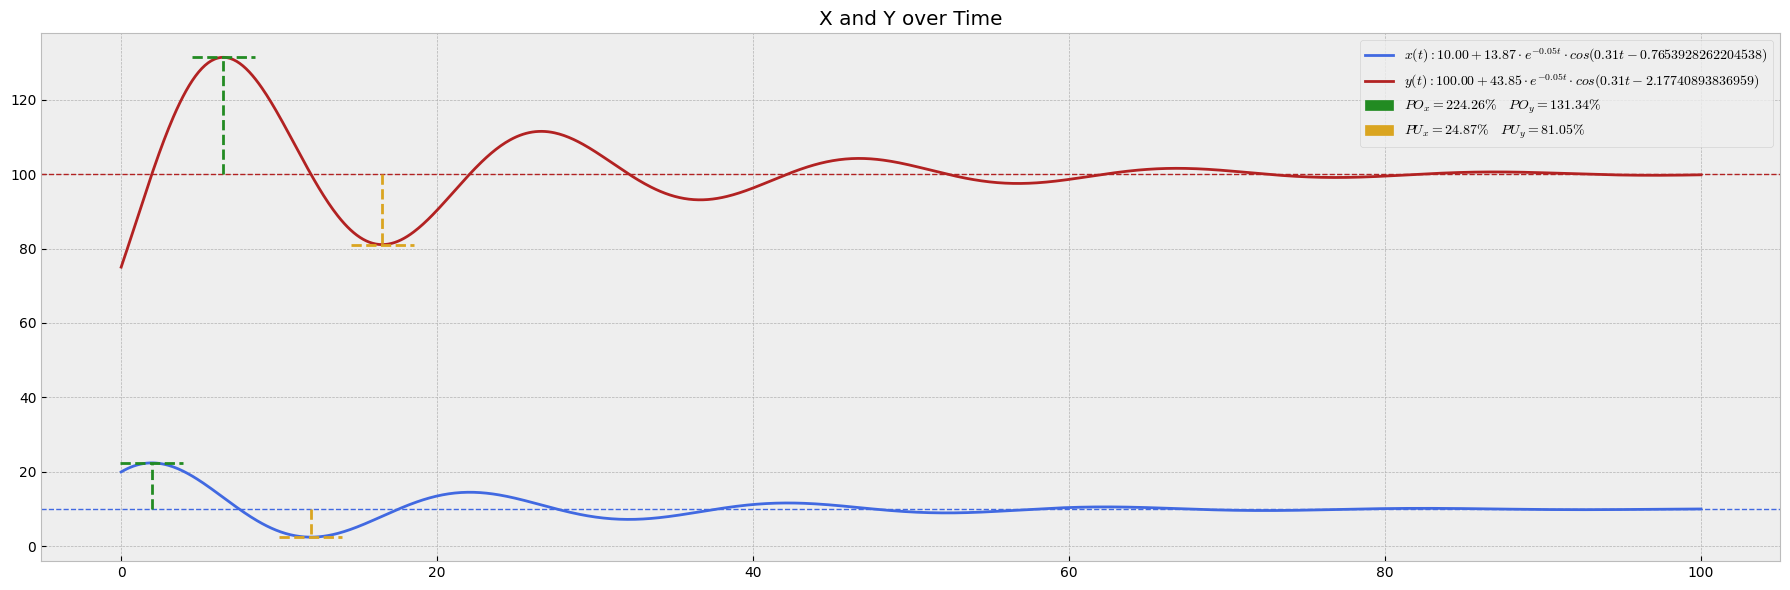

In [141]:
main(
    A=0,
    B=-0.1,
    C=1.00,
    D=-0.10,
    x_0=20,
    y_0=75,
    days=100,
);

In [96]:
-2 // 2

-1